In [1]:
from camera import take_picture
import pickle

In [31]:
def capture_image(port):
    """
    Takes in the desired port for image capture on the machine and returns (1) an RGB image array of shape (H,W,3)
    and (2) a list of descriptors which map to faces detected in the image.
    
    Parameters: 
    port: an integer that calls a specific port on the laptop depending on where the image is being taken
    
    Returns:
    img_array: a (H,W,3) array of image data
    descriptors: a list of (128,) descriptors of faces from img_array.
    detections: a list of dlib.rectangles with the coordinates of each face in the img_array
    
    """
    
    # first configure the camera
#     %matplotlib notebook
#     from camera import test_camera
#     fig, ax, img = test_camera(port=port, exposure=.3)

    # save that configuration
#     from camera import save_camera_config
#     save_camera_config(port=port, exposure=0.2)

    # get the (H,W,3) array of image data
    %matplotlib notebook
    from camera import take_picture
    import matplotlib.pyplot as plt
    img_array = take_picture()
    
    # get the (128,) image descriptor array
    import numpy as np
    
    # download the models from dlib
    from dlib_models import download_model, download_predictor, load_dlib_models
#     download_model()
#     download_predictor()
    from dlib_models import models
    
    # load the models that dlib has to detect faces.
#     load_dlib_models()
    face_detect = models["face detect"]
    face_rec_model = models["face rec"]
    shape_predictor = models["shape predict"]
    
    # Take in the (H,W,3) img_array and return the number of face detections in the photo
    detections = list(face_detect(img_array))
    
    # for each detected face, create a descriptor
    descriptors = []
    for image in range(len(detections)):
        shape = shape_predictor(img_array, detections[image])
        descriptor = np.array(face_rec_model.compute_face_descriptor(img_array, shape))
        descriptors.append(descriptor)
        
    return img_array, descriptors, detections


In [30]:
def imported_image(file_path):
    """
    Parameters:
        file_path: a file_path to an image that can be detected
        
    Returns:
        img_array: a (H,W,3) image array which prints the image from the filepath
        descriptors: a (128,) array descriptor
        detections: 
    """
    import PIL.Image
    img_array = PIL.Image.open(file_path)
    
    import numpy as np
    img_array = np.array(img_array)
    
    # download the models from dlib
    from dlib_models import download_model, download_predictor, load_dlib_models
#     download_model()
#     download_predictor()
    from dlib_models import models
    
#     # load the models that dlib has to detect faces.
#     load_dlib_models()
    face_detect = models["face detect"]
    face_rec_model = models["face rec"]
    shape_predictor = models["shape predict"]
    
    # Take in the (H,W,3) img_array and return the number of face detections in the photo
    detections = list(face_detect(img_array))
    
    # for each detected face, create a descriptor
    descriptors = []
    for image in range(len(detections)):
        shape = shape_predictor(img_array, detections[image])
        descriptor = np.array(face_rec_model.compute_face_descriptor(img_array, shape))
        descriptors.append(descriptor)
        
    return img_array, descriptors, detections

In [5]:
def print_faces(img_array, detections):
    """
    Parameters:
        img_array: a (H,W,3) array of image data
        detections: a list of dlib.rectangle objects
    """
    import matplotlib.pyplot as plt
    if(type(detections) != list):
        detections = list(detections)
        
        
    if len(detections) == 1:
        rect = detections[0]
        fig,ax = plt.subplots()
        x1,x2,y1,y2 = rect.left(), rect.right(), rect.top(), rect.bottom()
        ax.imshow(img_array[y1:y2,x1:x2,:])

    
    else:
        fig,ax = plt.subplots(ncols = len(detections))
        # https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly
        for i, rect in enumerate(detections):
            x1,x2,y1,y2 = rect.left(), rect.right(), rect.top(), rect.bottom()
            ax[i].imshow(img_array[y1:y2,x1:x2,:])
            ax[i].axis('off')



In [6]:
def import_pickle():
    """
    Returns:
    faces: a dictionary with key, value of face and associated descriptors.
    """
    faces={}
    with open("faces.pkl", mode="rb") as opened_file:
        faces=pickle.load(opened_file)
    return faces

In [7]:
def pickle_the_pickle(faces_dictionary):
    """
    Takes in a dictionary of face labels and associated descriptors and populates a pickle.
    
    Parameters:
    faces_dictionary: a dictionary where key, value is face label, associated descriptors
    """
    with open("faces.pkl", mode="wb") as opened_file:
        pickle.dump(faces_dictionary, opened_file)
    print("The Pickle has been pickled")

In [8]:
def new_pickle():
    """This is only for emergeny
    Think before you tickle our pickle
    clears the pickle"""
    with open("faces.pkl", mode="wb") as opened_file:
        pickle.dump({}, opened_file)

In [9]:
def log_into_database(descriptor,name):
    """
    Parameters:
        descriptor: a (128,) array that describes the img_array input
        name: the name associated with the descriptor
    """
    
    #assert len(descriptor) == 128
    faces = import_pickle()
    if name in faces.keys():
        faces[name].append(descriptor)
    else:
        faces.update([(name,descriptor)])
    pickle_the_pickle(faces)

In [41]:
def search(descriptor):
    """
    Finds probable labels for whatever descriptors are input.
    Parameters:
        descriptor: an array of (128,) to describe a person
    Returns:
        probable_faces: a list of probable names to describe the descriptor
    """
    import numpy as np
    faces = import_pickle()
    distances = []
    
    for name in list(faces.keys()):
        mean = np.mean(faces[name],axis=0) # takes elementwise mean
        distances.append(euclidean_distance(mean,descriptor))
    
    print(distances)
    # populate a list with probable names within the threshold
    probable_faces = []
    threshold = .4
    for i, distance in enumerate(distances):
        if distance < threshold:
            probable_faces.append(list(faces.keys())[i])
    
    # todo: figure out the threshold value. will we be able to return just one?
    print(probable_faces)
    return probable_faces
        
        

In [11]:
def rect_coordinates(rect):
    """
    Takes a dlib.rectangle object and pulls the x1,x2,y1,y2 coordinates
    which maps to the rectangle.
    Parameters:
        rect: a dlib.rectangle object
        
    Returns:
        x1,y1,x2,y2: a list of coordinates which will map to a space on an image
    """
    x1,y1,x2,y2 = rect.left(), rect.right(), rect.top(), rect.bottom()
    
    return x1,y1,x2,y2

In [12]:
def euclidean_distance(arr1,arr2):
    """
    Returns the euclidean distance between two matrices.
    """
    import numpy as np
    distance = np.sqrt(np.sum((arr1 - arr2)**2))
    return distance

In [38]:
def final_func(func, port = 0,name = "",pictures = [],path = ""):
    """
    Parameters:
        func: One of several functions
            imgcapture_log: logs photos into the database through camera
                REQUIRED PARAMETERS:: name
            imgcapture_search: searches through images based on a camera input
                REQUIRED PARAMETERS:: none
            imgfile_log: logs photos based on file input
                REQUIRED PARAMETERS:: path, name
            imgfile_search:
                REQUIRED PARAMETERS: path
        port: the port by which your computer's camera takes image input
        path: in the directory of pics/ , each person has their own folder by their own name with pictures of them
    """
    import os
    
    full_path = "pics/" + path
    imgs = []
            
    if func == "imgfile_log":
        # iterate through the names of contents of the folder
        # image_path is name of file in directory; full_path is the path to the folder of a specific person
        for image_path in os.listdir(full_path):
                input_path = os.path.join(full_path,image_path)
                imgs.append(input_path)
        # if there are images in the path and we recieve a name, we are LOGGING IN DATABASE
        if ((len(imgs) != 0) & (name != "")):
            for picture in imgs:
                img_array, descriptors, detections = imported_image(picture)
                if (descriptors == []):
                    continue
                print_faces(img_array,detections)
                log_into_database(descriptors,path)
    
    elif func == "imgfile_search":
        # this is the SEARCH FUNCTION - a name is not given but we recieve a photo
        # iterate through the names of contents of the folder
        # image_path is name of file in directory; full_path is the path to the folder of a specific person
        for image_path in os.listdir(full_path):
                input_path = os.path.join(full_path,image_path)
                imgs.append(input_path)
        for picture in imgs:
            # assuming pictures is a list of 1, we will still have to index into it
            img_array, descriptors, detections = imported_image(picture)
            print_faces(img_array,detections)
            for descriptor in descriptors:
                search(descriptor)
    
    elif func == "imgcapture_log":
        # we do not recieve a photo but we recieve a name - we are LOGGING THROUGH IMAGE CAPTURE
        if (len(pictures) == 0) & (name != ""):
            img_array, descriptors, detections = capture_image(port)
            if (descriptors == []):
                pass
            print_faces(img_array,detections)
            log_into_database(descriptors,name)        
    
    elif func == "imgcapture_search":
        img_array, descriptors, detections = capture_image(port)
        if (descriptors == []):
                print("We don't see you")
                pass
        print_faces(img_array,detections) 
        for descriptor in descriptors:
            search(descriptor)

<IPython.core.display.Javascript object>


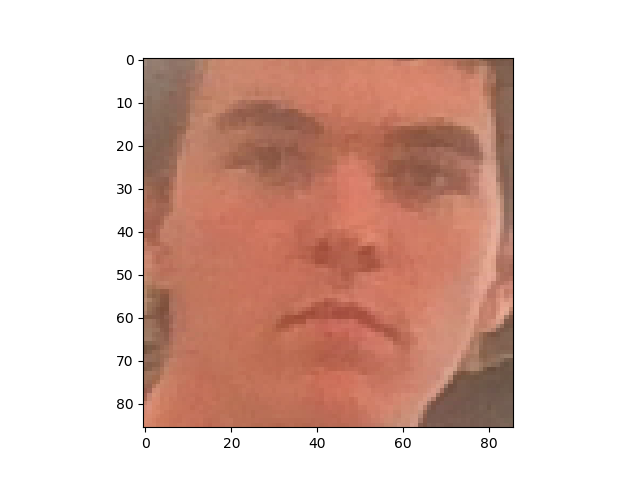

[0.7632880596665492, 0.34496904882982643, 0.8162297120503509, 0.6379718409770432]
['Ryan']


In [40]:
final_func(func = "imgcapture_search")